In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4,dask

Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.1
xarray 0.9.1
netCDF4 1.2.4
dask 0.15.2
Wed Aug 30 14:12:18 2017 CEST

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [3]:
## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd 
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar

%matplotlib inline

In [4]:
## datasets

#ARGO
dir_ar="/media/extra/DATA/ARGO/"
file072012="EN.4.2.0.f.profiles.g10.201207.nc"

tfile072012=dir_ar+file072012

!ls $tfile072012

/media/extra/DATA/ARGO/EN.4.2.0.f.profiles.g10.201207.nc


In [5]:
#NATL60

dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/"
files="NATL60-CJM165_y2012m07d*.1d_gridT.nc"

tfiles=dir+files

!ls $tfiles


/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d01.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d02.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d03.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d04.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d05.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d06.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d07.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d08.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d09.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d10.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d11.1d_gridT.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/3d/NATL60-CJM165_y2012m07d12.1d_gridT.nc
/media/extra/DAT

In [6]:
##Open NATL60 files to get boundaries of domain

dsN = xr.open_mfdataset(tfiles,concat_dim='time_counter',decode_times=False, chunks={'deptht':1 ,'time_counter':1})

latN = dsN.nav_lat
lonN = dsN.nav_lon
tempN=dsN.votemper
saltN=dsN.vosaline
depN = dsN.deptht
timN = dsN.time_counter

lamin=np.nanmin(latN.values)
lamax=np.nanmax(latN.values)
lomin=np.nanmin(lonN.values)
lomax=np.nanmax(lonN.values)

print lamin,lamax,lomin,lomax

26.5648 67.3871 -86.255 17.7867


In [7]:
##Select one ARGO profile sampled at 15/06/2012 and within NATL60 boundaries¶

argo072012=xr.open_dataset(tfile072012)
dep_ar=argo072012['DEPH_CORRECTED']
lat_ar=argo072012['LATITUDE']
lon_ar=argo072012['LONGITUDE']
temp_ar=argo072012['POTM_CORRECTED']
salt_ar=argo072012['PSAL_CORRECTED']
day_ar=argo072012['JULD']

lon_arNbox = lon_ar.sel(N_PROF=(lon_ar>lomin)&(lon_ar<lomax)&(lat_ar>lamin)&(lat_ar<lamax), drop=True)    
lat_arNbox = lat_ar.sel(N_PROF=(lon_ar>lomin)&(lon_ar<lomax)&(lat_ar>lamin)&(lat_ar<lamax), drop=True)    
temp_arNbox = temp_ar.sel(N_PROF=(lon_ar>lomin)&(lon_ar<lomax)&(lat_ar>lamin)&(lat_ar<lamax), drop=True)    
salt_arNbox = salt_ar.sel(N_PROF=(lon_ar>lomin)&(lon_ar<lomax)&(lat_ar>lamin)&(lat_ar<lamax), drop=True)    
dep_arNbox = dep_ar.sel(N_PROF=(lon_ar>lomin)&(lon_ar<lomax)&(lat_ar>lamin)&(lat_ar<lamax), drop=True)    
day_arNbox = day_ar.sel(N_PROF=(lon_ar>lomin)&(lon_ar<lomax)&(lat_ar>lamin)&(lat_ar<lamax), drop=True)

def find_date(day_ar,year,month,tday):
    prof=[]
    date=day_ar.values[:]
    for t in np.arange(0,len(date)):
        ts = pd.to_datetime(str(day_ar.values[t])) 
        dyear=ts.strftime('%Y')
        dmonth=ts.strftime('%m')
        dday=ts.strftime('%d')
        if dyear == year:
            if dmonth == month:
                if dday == tday:
                    prof.append(t)
        aprof=np.array(prof)
    return aprof

t15=find_date(day_arNbox,'2012','07','15')





In [8]:
prof_argo=0

#select NATL60 data at the closest depth and within 250m and 15days near the location and date of the ARGO profile
observation_lon=lon_arNbox[t15[prof_argo]].values
observation_lat=lat_arNbox[t15[prof_argo]].values
observation_dep=dep_arNbox[t15[prof_argo]].values
observation_temp=temp_arNbox[t15[prof_argo]].values
observation_salt=salt_arNbox[t15[prof_argo]].values

print observation_lon,observation_lat

dep_level=np.zeros(1)

for k in np.arange(len(observation_dep)):
    if not np.isnan(observation_dep[k]):
        dep_level[0]=k
        
print dep_level

model_level=np.zeros(dep_level[0])
model_dep=np.zeros(dep_level[0])
for z in np.arange(dep_level[0]):
    obs_dep=observation_dep[z]
    diff_dep=0*depN.values
    for k in np.arange(len(depN.values)):
        diff_dep[k]=depN.values[k]-obs_dep
    lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
    model_level[z]=lev[0]
    model_dep[z]=depN.values[lev[0]]
    
step=3
indxBOX=np.where((lonN>observation_lon-1)&(lonN<observation_lon+1)&(latN>observation_lat-1)&(latN<observation_lat+1))  
model_lonBOX=lonN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
model_latBOX=latN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
model_lonBOX_array=model_lonBOX.values
model_latBOX_array=model_latBOX.values
t_dim=np.arange(len(timN.values))
x_dim=np.arange(model_lonBOX_array.shape[1])
y_dim=np.arange(model_lonBOX_array.shape[0])


k=0
#decoupage grossier autour de la position du profile ARGO pour un niveau vertical
    
model_tempBOX=tempN[:,k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
model_saltBOX=saltN[:,k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
    
model_tempBOX_array=model_tempBOX.values
model_saltBOX_array=model_saltBOX.values
time_array=timN.values

# construction d'un nouveau xarray
d = {}
d['time_counter'] = ('time_counter',t_dim)
d['y'] = ('y',y_dim)
d['x'] = ('x',x_dim)
d['nav_lat'] = (['y','x'],model_latBOX_array)
d['nav_lon'] = (['y','x'],model_lonBOX_array)
    
d['votemper'] = (['time_counter','y','x'], model_tempBOX_array)
d['vosaline'] = (['time_counter','y','x'], model_saltBOX_array)
    
dset = xr.Dataset(d)
        
latB = dset.nav_lat
lonB = dset.nav_lon
model_temperatureB = dset.votemper
model_salinityB = dset.vosaline
    
# selection plus fine des profils
    
model_temperature_stacked = model_temperatureB.stack(profile=('x', 'y'))
model_salinity_stacked = model_salinityB.stack(profile=('x', 'y'))
lon_stacked = lonB.stack(profile=('x', 'y'))
lat_stacked = latB.stack(profile=('x', 'y'))
    
distance_threshold = 0.25
square_distance_to_observation = (lon_stacked - observation_lon)**2 + (lat_stacked-observation_lat)**2
is_close_to_observation = square_distance_to_observation < distance_threshold**2
    
model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
lat_near_observation = lat_stacked.where(is_close_to_observation, drop=True)
lon_near_observation = lon_stacked.where(is_close_to_observation, drop=True)

print model_temperature_near_observation.shape

model_temp_dask=dask.array.from_array(model_temperature_near_observation,chunks=(100,100))
model_temp_dask_concat=dask.array.concatenate(model_temp_dask)

print model_temp_dask_concat.mean()
print model_temp_dask_concat.percentile(0.1)
print model_temp_dask_concat.percentile(0.9)




-31.141 47.671
[ 76.]


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(31, 107)
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>


AttributeError: 'Array' object has no attribute 'percentile'

In [35]:
model_temp_dask_concat.quantile(10)

AttributeError: 'Array' object has no attribute 'quantile'

In [33]:
a=np.percentile(model_temp_dask_concat,10)

In [34]:
print a

14.2623746872


In [21]:
print model_temp_dask_concat.mean().compute()

15.2177715549


In [40]:
def model_profile_temp_salt_mean_percent10_90(prof_argo):

    #select NATL60 data at the closest depth and within 250m and 15days near the location and date of the ARGO profile
    observation_lon=lon_arNbox[t15[prof_argo]].values
    observation_lat=lat_arNbox[t15[prof_argo]].values
    observation_dep=dep_arNbox[t15[prof_argo]].values
    observation_temp=temp_arNbox[t15[prof_argo]].values
    observation_salt=salt_arNbox[t15[prof_argo]].values

    print observation_lon,observation_lat

    dep_level=np.zeros(1)

    for k in np.arange(len(observation_dep)):
        if not np.isnan(observation_dep[k]):
            dep_level[0]=k
        
    print dep_level

    model_level=np.zeros(dep_level[0])
    model_dep=np.zeros(dep_level[0])
    for z in np.arange(dep_level[0]):
        obs_dep=observation_dep[z]
        diff_dep=0*depN.values
        for k in np.arange(len(depN.values)):
            diff_dep[k]=depN.values[k]-obs_dep
        lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
        model_level[z]=lev[0]
        model_dep[z]=depN.values[lev[0]]
    
    step=3
    indxBOX=np.where((lonN>observation_lon-1)&(lonN<observation_lon+1)&(latN>observation_lat-1)&(latN<observation_lat+1))  
    model_lonBOX=lonN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
    model_latBOX=latN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
    model_lonBOX_array=model_lonBOX.values
    model_latBOX_array=model_latBOX.values
    t_dim=np.arange(len(timN.values))
    x_dim=np.arange(model_lonBOX_array.shape[1])
    y_dim=np.arange(model_lonBOX_array.shape[0])


    def profile_mean_percent(k):

        #decoupage grossier autour de la position du profile ARGO pour un niveau vertical
    
        model_tempBOX=tempN[:,k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_saltBOX=saltN[:,k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
    
        model_tempBOX_array=model_tempBOX.values
        model_saltBOX_array=model_saltBOX.values
        time_array=timN.values

        # construction d'un nouveau xarray
        d = {}
        d['time_counter'] = ('time_counter',t_dim)
        d['y'] = ('y',y_dim)
        d['x'] = ('x',x_dim)
        d['nav_lat'] = (['y','x'],model_latBOX_array)
        d['nav_lon'] = (['y','x'],model_lonBOX_array)
    
        d['votemper'] = (['time_counter','y','x'], model_tempBOX_array)
        d['vosaline'] = (['time_counter','y','x'], model_saltBOX_array)
    
        dset = xr.Dataset(d)
        
        latB = dset.nav_lat
        lonB = dset.nav_lon
        model_temperatureB = dset.votemper
        model_salinityB = dset.vosaline
    
        # selection plus fine des profils
    
        model_temperature_stacked = model_temperatureB.stack(profile=('x', 'y'))
        model_salinity_stacked = model_salinityB.stack(profile=('x', 'y'))
        lon_stacked = lonB.stack(profile=('x', 'y'))
        lat_stacked = latB.stack(profile=('x', 'y'))
    
        distance_threshold = 0.25
        square_distance_to_observation = (lon_stacked - observation_lon)**2 + (lat_stacked-observation_lat)**2
        is_close_to_observation = square_distance_to_observation < distance_threshold**2
    
        model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
        model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
        lat_near_observation = lat_stacked.where(is_close_to_observation, drop=True)
        lon_near_observation = lon_stacked.where(is_close_to_observation, drop=True)
        
        model_temp_dask=dask.array.from_array(model_temperature_near_observation,chunks=(100,100))
        model_temp_dask_concat=dask.array.concatenate(model_temp_dask)
        model_salt_dask=dask.array.from_array(model_salinity_near_observation,chunks=(100,100))
        model_salt_dask_concat=dask.array.concatenate(model_salt_dask)
    
        temp_model_mean = model_temp_dask_concat.mean().compute()
        temp_percentile_10= np.percentile(model_temp_dask_concat,10)
        temp_percentile_90= np.percentile(model_temp_dask_concat,90)
        salt_model_mean = model_salt_dask_concat.mean().compute()
        salt_percentile_10= np.percentile(model_salt_dask_concat,10)
        salt_percentile_90= np.percentile(model_salt_dask_concat,90)

        return lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90

    profil_temp_model_mean=np.zeros(dep_level[0])
    profil_temp_model_percent10=np.zeros(dep_level[0])
    profil_temp_model_percent90=np.zeros(dep_level[0])
    profil_salt_model_mean=np.zeros(dep_level[0])
    profil_salt_model_percent10=np.zeros(dep_level[0])
    profil_salt_model_percent90=np.zeros(dep_level[0])


    for z in np.arange(dep_level[0]):
        lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90=profile_mean_percent(model_level[z].astype(int))
        profil_temp_model_mean[z]=temp_model_mean
        profil_temp_model_percent10[z]=temp_percentile_10
        profil_temp_model_percent90[z]=temp_percentile_90
        profil_salt_model_mean[z]=salt_model_mean
        profil_salt_model_percent10[z]=salt_percentile_10
        profil_salt_model_percent90[z]=salt_percentile_90
        
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[2,2])

    fig1 = plt.figure(figsize=(14, 16))  # (w,h)
    ax0b = plt.subplot(gs[0, 0])
    ax0 = plt.subplot(gs[0, 1])

    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[1, 1])

    my_map0 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', ax = ax0b,
    llcrnrlon = observation_lon-20, llcrnrlat= observation_lat-20,
    urcrnrlon = observation_lon+20, urcrnrlat = observation_lat+20, area_thresh = 10)

    my_map0.drawcoastlines() 
    my_map0.drawmapboundary()
    my_map0.drawmeridians(np.arange(-120, 60, 10), labels=[1,0,0,1], size=18)
    my_map0.drawparallels(np.arange(0, 80, 10), labels=[1,0,0,1], size=18)
    my_map0.scatter(lon_near_observation.values, lat_near_observation.values, latlon=True, c='r', linewidth='0', s=1)
    my_map0.scatter(observation_lon, observation_lat, latlon=True, c='g', linewidth='0', s=10)

    my_map1 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', ax = ax0,
    llcrnrlon = observation_lon-1, llcrnrlat= observation_lat-1,
    urcrnrlon = observation_lon+1, urcrnrlat = observation_lat+1, area_thresh = 10)

    my_map1.drawcoastlines() 
    my_map1.drawmapboundary()
    my_map1.drawmeridians(np.arange(-120, 60, 1), labels=[1,0,0,1], size=18)
    my_map1.drawparallels(np.arange(0, 80, 1), labels=[1,0,0,1], size=18)
    my_map1.scatter(lon_near_observation.values, lat_near_observation.values, latlon=True, c='r', linewidth='0', s=1)
    my_map1.scatter(observation_lon, observation_lat, latlon=True, c='g', linewidth='0', s=10)

    ax1.plot(observation_temp,observation_dep,'b.-')
    ax1.set_xlabel('Potential temperature [$^\circ$C]', size=16)
    ax1.set_ylabel('Depth [m]', size=14)
    ax1.set_ylim(np.nanmax(observation_dep) + 10, 0)
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    ax1.plot(profil_temp_model_mean, model_dep, 'r.-', label='Natl60')
    ax1.plot(profil_temp_model_percent10, model_dep, 'r-', label='Percentile 10-90')
    ax1.plot(profil_temp_model_percent90, model_dep, 'r-')
    ax1.fill_betweenx(model_dep, profil_temp_model_percent10, x2=profil_temp_model_percent90, alpha=0.2, facecolor='r')

    ax2.plot(observation_salt,observation_dep,'b.-')
    ax2.set_xlabel('Practical salinity [psu]', size=16)
    ax2.set_ylabel('Depth [m]', size=14)
    ax2.set_ylim(np.nanmax(observation_dep) + 10, 0)
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.plot(profil_salt_model_mean, model_dep, 'r.-', label='Natl60')
    ax2.plot(profil_salt_model_percent10, model_dep, 'r-', label='Percentile 10-90')
    ax2.plot(profil_salt_model_percent90, model_dep, 'r-')
    ax2.fill_betweenx(model_dep, profil_salt_model_percent10, x2=profil_salt_model_percent90, alpha=0.2, facecolor='r')
    
    plt.savefig('/media/extra/DATA/NATL60/NATL60-CJM165-PLOTS/comp_argo/comp_temp_salt_15072012_NATL60_ARGO'+str(prof_argo)+'.png')

-31.141 47.671
[ 76.]


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-pac

-31.141 47.671
[ 76.]
-31.141 47.671
[ 76.]
-31.141 47.671
[ 76.]
1 loop, best of 3: 6min 5s per loop


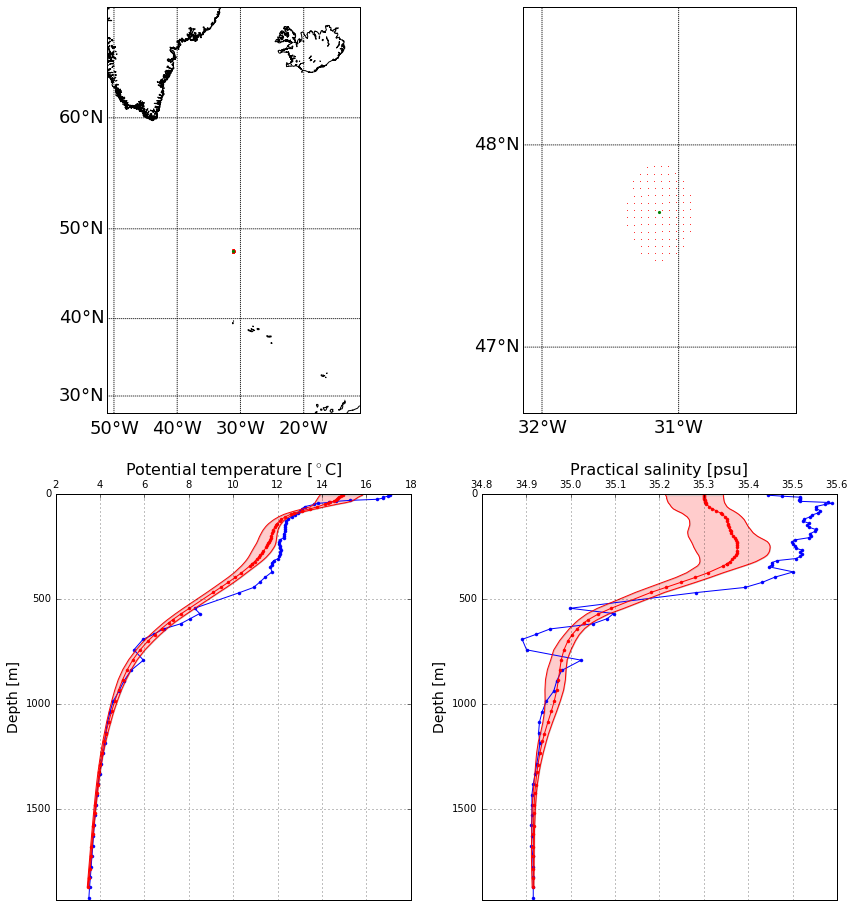

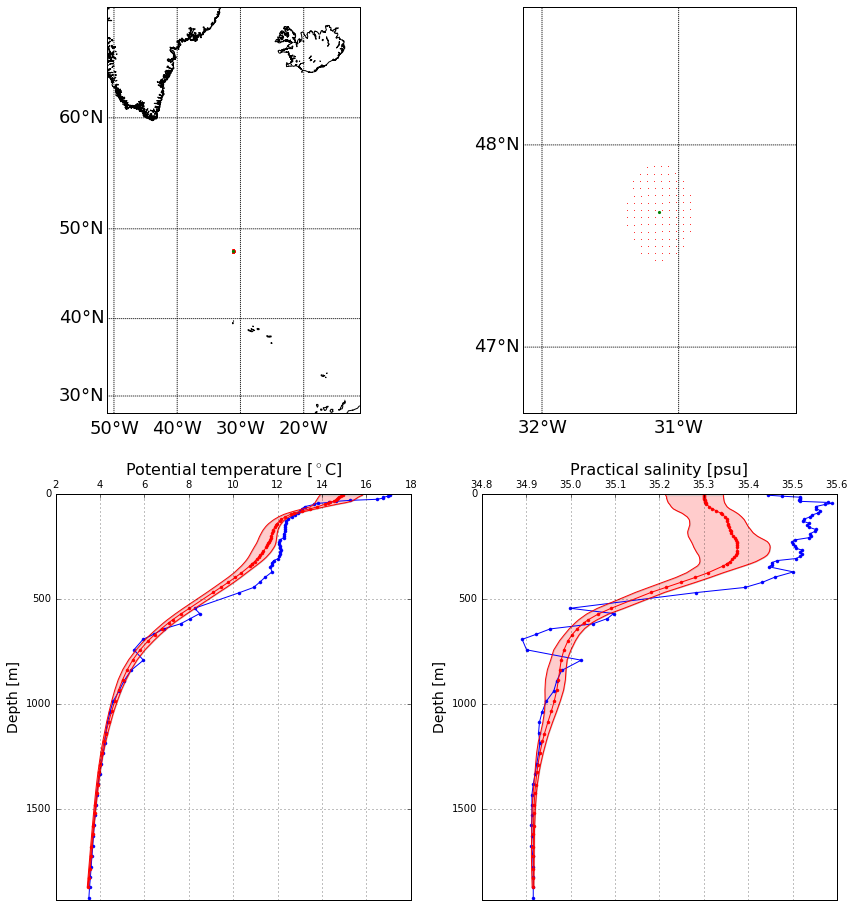

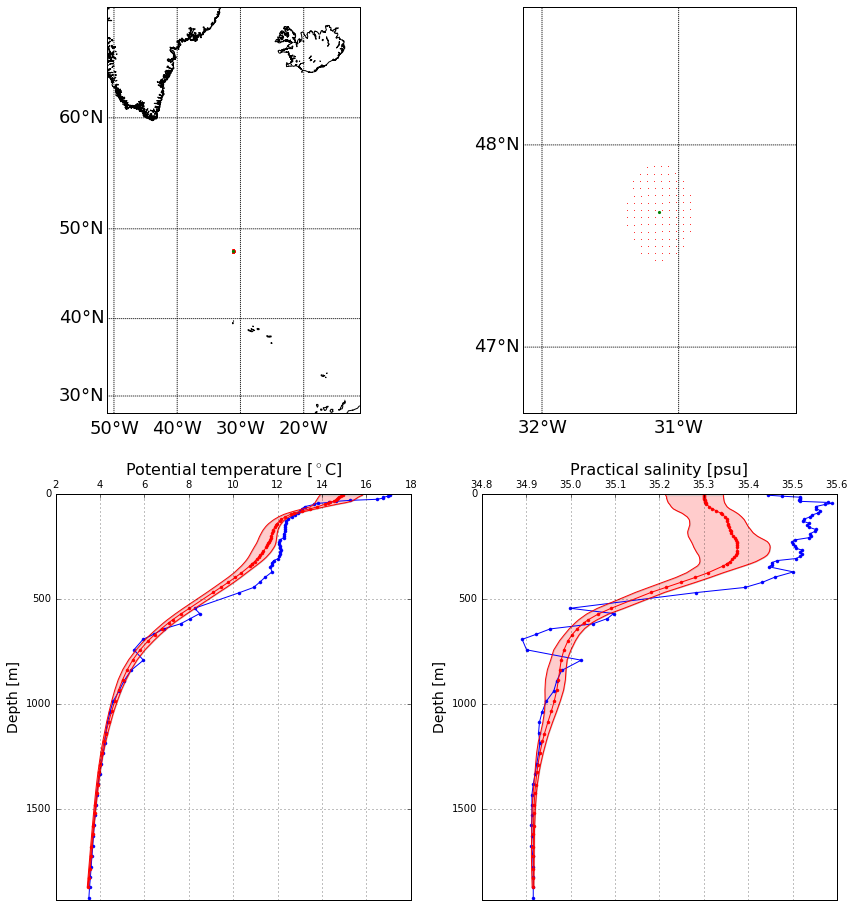

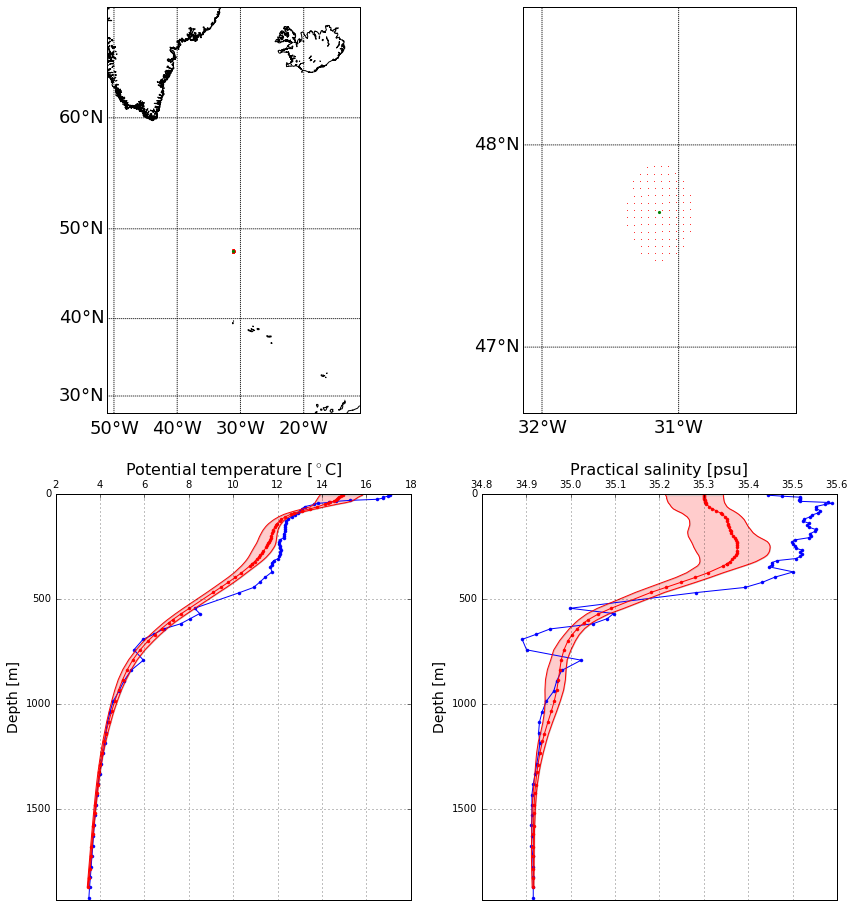

In [41]:
%timeit model_profile_temp_salt_mean_percent10_90(0)

In [44]:
def model_profile_temp_salt_mean_percent10_90(prof_argo):

    #select NATL60 data at the closest depth and within 250m and 15days near the location and date of the ARGO profile
    observation_lon=lon_arNbox[t15[prof_argo]].values
    observation_lat=lat_arNbox[t15[prof_argo]].values
    observation_dep=dep_arNbox[t15[prof_argo]].values
    observation_temp=temp_arNbox[t15[prof_argo]].values
    observation_salt=salt_arNbox[t15[prof_argo]].values

    print observation_lon,observation_lat

    dep_level=np.zeros(1)

    for k in np.arange(len(observation_dep)):
        if not np.isnan(observation_dep[k]):
            dep_level[0]=k
        
    print dep_level

    model_level=np.zeros(dep_level[0])
    model_dep=np.zeros(dep_level[0])
    for z in np.arange(dep_level[0]):
        obs_dep=observation_dep[z]
        diff_dep=0*depN.values
        for k in np.arange(len(depN.values)):
            diff_dep[k]=depN.values[k]-obs_dep
        lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
        model_level[z]=lev[0]
        model_dep[z]=depN.values[lev[0]]
    
    indxBOX=np.where((lonN>observation_lon-1)&(lonN<observation_lon+1)&(latN>observation_lat-1)&(latN<observation_lat+1))  
    model_lonBOX=lonN[np.min(indxBOX[0]):np.max(indxBOX[0]),np.min(indxBOX[1]):np.max(indxBOX[1])]
    model_latBOX=latN[np.min(indxBOX[0]):np.max(indxBOX[0]),np.min(indxBOX[1]):np.max(indxBOX[1])]
    model_lonBOX_array=model_lonBOX.values
    model_latBOX_array=model_latBOX.values
    t_dim=np.arange(len(timN.values))
    x_dim=np.arange(model_lonBOX_array.shape[1])
    y_dim=np.arange(model_lonBOX_array.shape[0])


    def profile_mean_percent(k):

        #decoupage grossier autour de la position du profile ARGO pour un niveau vertical
    
        model_tempBOX=tempN[:,k,np.min(indxBOX[0]):np.max(indxBOX[0]),np.min(indxBOX[1]):np.max(indxBOX[1])]
        model_saltBOX=saltN[:,k,np.min(indxBOX[0]):np.max(indxBOX[0]),np.min(indxBOX[1]):np.max(indxBOX[1])]
    
        model_tempBOX_array=model_tempBOX.values
        model_saltBOX_array=model_saltBOX.values
        time_array=timN.values

        # construction d'un nouveau xarray
        d = {}
        d['time_counter'] = ('time_counter',t_dim)
        d['y'] = ('y',y_dim)
        d['x'] = ('x',x_dim)
        d['nav_lat'] = (['y','x'],model_latBOX_array)
        d['nav_lon'] = (['y','x'],model_lonBOX_array)
    
        d['votemper'] = (['time_counter','y','x'], model_tempBOX_array)
        d['vosaline'] = (['time_counter','y','x'], model_saltBOX_array)
    
        dset = xr.Dataset(d)
        
        latB = dset.nav_lat
        lonB = dset.nav_lon
        model_temperatureB = dset.votemper
        model_salinityB = dset.vosaline
    
        # selection plus fine des profils
    
        model_temperature_stacked = model_temperatureB.stack(profile=('x', 'y'))
        model_salinity_stacked = model_salinityB.stack(profile=('x', 'y'))
        lon_stacked = lonB.stack(profile=('x', 'y'))
        lat_stacked = latB.stack(profile=('x', 'y'))
    
        distance_threshold = 0.25
        square_distance_to_observation = (lon_stacked - observation_lon)**2 + (lat_stacked-observation_lat)**2
        is_close_to_observation = square_distance_to_observation < distance_threshold**2
    
        model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
        model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
        lat_near_observation = lat_stacked.where(is_close_to_observation, drop=True)
        lon_near_observation = lon_stacked.where(is_close_to_observation, drop=True)
        
        model_temp_dask=dask.array.from_array(model_temperature_near_observation,chunks=(100,100))
        model_temp_dask_concat=dask.array.concatenate(model_temp_dask)
        model_salt_dask=dask.array.from_array(model_salinity_near_observation,chunks=(100,100))
        model_salt_dask_concat=dask.array.concatenate(model_salt_dask)
    
        temp_model_mean = model_temp_dask_concat.mean().compute()
        temp_percentile_10= np.percentile(model_temp_dask_concat,10)
        temp_percentile_90= np.percentile(model_temp_dask_concat,90)
        salt_model_mean = model_salt_dask_concat.mean().compute()
        salt_percentile_10= np.percentile(model_salt_dask_concat,10)
        salt_percentile_90= np.percentile(model_salt_dask_concat,90)

        return lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90

    profil_temp_model_mean=np.zeros(dep_level[0])
    profil_temp_model_percent10=np.zeros(dep_level[0])
    profil_temp_model_percent90=np.zeros(dep_level[0])
    profil_salt_model_mean=np.zeros(dep_level[0])
    profil_salt_model_percent10=np.zeros(dep_level[0])
    profil_salt_model_percent90=np.zeros(dep_level[0])


    for z in np.arange(dep_level[0]):
        lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90=profile_mean_percent(model_level[z].astype(int))
        profil_temp_model_mean[z]=temp_model_mean
        profil_temp_model_percent10[z]=temp_percentile_10
        profil_temp_model_percent90[z]=temp_percentile_90
        profil_salt_model_mean[z]=salt_model_mean
        profil_salt_model_percent10[z]=salt_percentile_10
        profil_salt_model_percent90[z]=salt_percentile_90
        
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[2,2])

    fig1 = plt.figure(figsize=(14, 16))  # (w,h)
    ax0b = plt.subplot(gs[0, 0])
    ax0 = plt.subplot(gs[0, 1])

    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[1, 1])

    my_map0 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', ax = ax0b,
    llcrnrlon = observation_lon-20, llcrnrlat= observation_lat-20,
    urcrnrlon = observation_lon+20, urcrnrlat = observation_lat+20, area_thresh = 10)

    my_map0.drawcoastlines() 
    my_map0.drawmapboundary()
    my_map0.drawmeridians(np.arange(-120, 60, 10), labels=[1,0,0,1], size=18)
    my_map0.drawparallels(np.arange(0, 80, 10), labels=[1,0,0,1], size=18)
    my_map0.scatter(lon_near_observation.values, lat_near_observation.values, latlon=True, c='r', linewidth='0', s=1)
    my_map0.scatter(observation_lon, observation_lat, latlon=True, c='g', linewidth='0', s=10)

    my_map1 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', ax = ax0,
    llcrnrlon = observation_lon-1, llcrnrlat= observation_lat-1,
    urcrnrlon = observation_lon+1, urcrnrlat = observation_lat+1, area_thresh = 10)

    my_map1.drawcoastlines() 
    my_map1.drawmapboundary()
    my_map1.drawmeridians(np.arange(-120, 60, 1), labels=[1,0,0,1], size=18)
    my_map1.drawparallels(np.arange(0, 80, 1), labels=[1,0,0,1], size=18)
    my_map1.scatter(lon_near_observation.values, lat_near_observation.values, latlon=True, c='r', linewidth='0', s=1)
    my_map1.scatter(observation_lon, observation_lat, latlon=True, c='g', linewidth='0', s=10)

    ax1.plot(observation_temp,observation_dep,'b.-')
    ax1.set_xlabel('Potential temperature [$^\circ$C]', size=16)
    ax1.set_ylabel('Depth [m]', size=14)
    ax1.set_ylim(np.nanmax(observation_dep) + 10, 0)
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    ax1.plot(profil_temp_model_mean, model_dep, 'r.-', label='Natl60')
    ax1.plot(profil_temp_model_percent10, model_dep, 'r-', label='Percentile 10-90')
    ax1.plot(profil_temp_model_percent90, model_dep, 'r-')
    ax1.fill_betweenx(model_dep, profil_temp_model_percent10, x2=profil_temp_model_percent90, alpha=0.2, facecolor='r')

    ax2.plot(observation_salt,observation_dep,'b.-')
    ax2.set_xlabel('Practical salinity [psu]', size=16)
    ax2.set_ylabel('Depth [m]', size=14)
    ax2.set_ylim(np.nanmax(observation_dep) + 10, 0)
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.plot(profil_salt_model_mean, model_dep, 'r.-', label='Natl60')
    ax2.plot(profil_salt_model_percent10, model_dep, 'r-', label='Percentile 10-90')
    ax2.plot(profil_salt_model_percent90, model_dep, 'r-')
    ax2.fill_betweenx(model_dep, profil_salt_model_percent10, x2=profil_salt_model_percent90, alpha=0.2, facecolor='r')
    
    plt.savefig('/media/extra/DATA/NATL60/NATL60-CJM165-PLOTS/comp_argo/comp_temp_salt_15072012_NATL60_ARGO'+str(prof_argo)+'.png')

-31.141 47.671
[ 76.]


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-pac

-31.141 47.671
[ 76.]
-31.141 47.671
[ 76.]
-31.141 47.671
[ 76.]
1 loop, best of 3: 4min 19s per loop


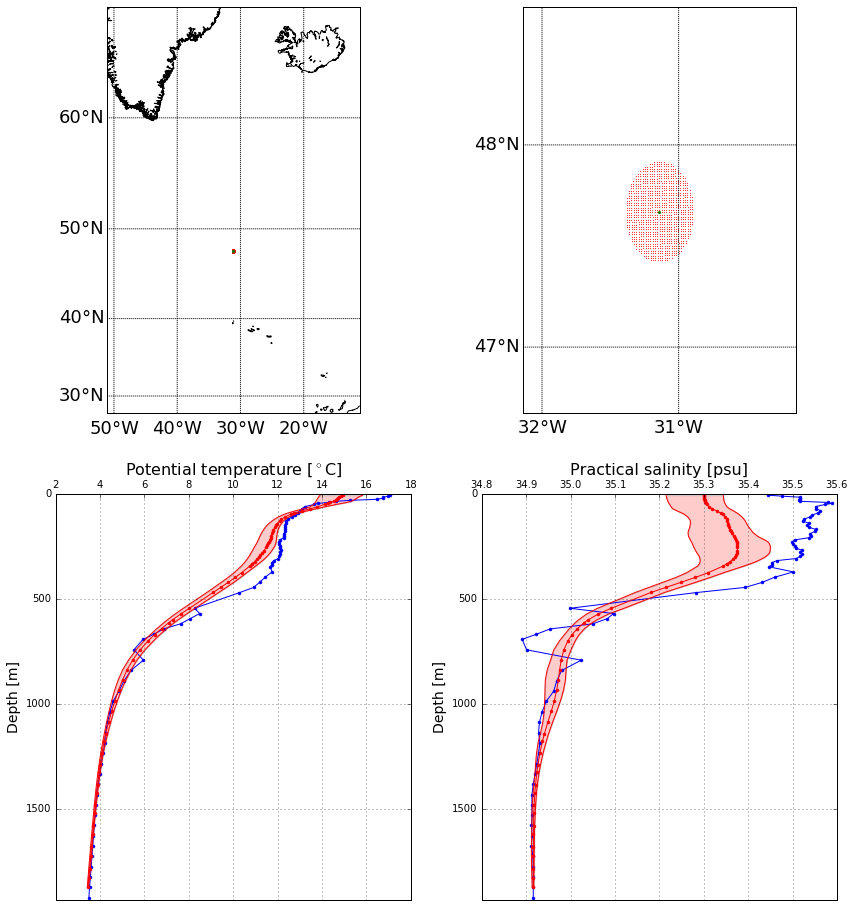

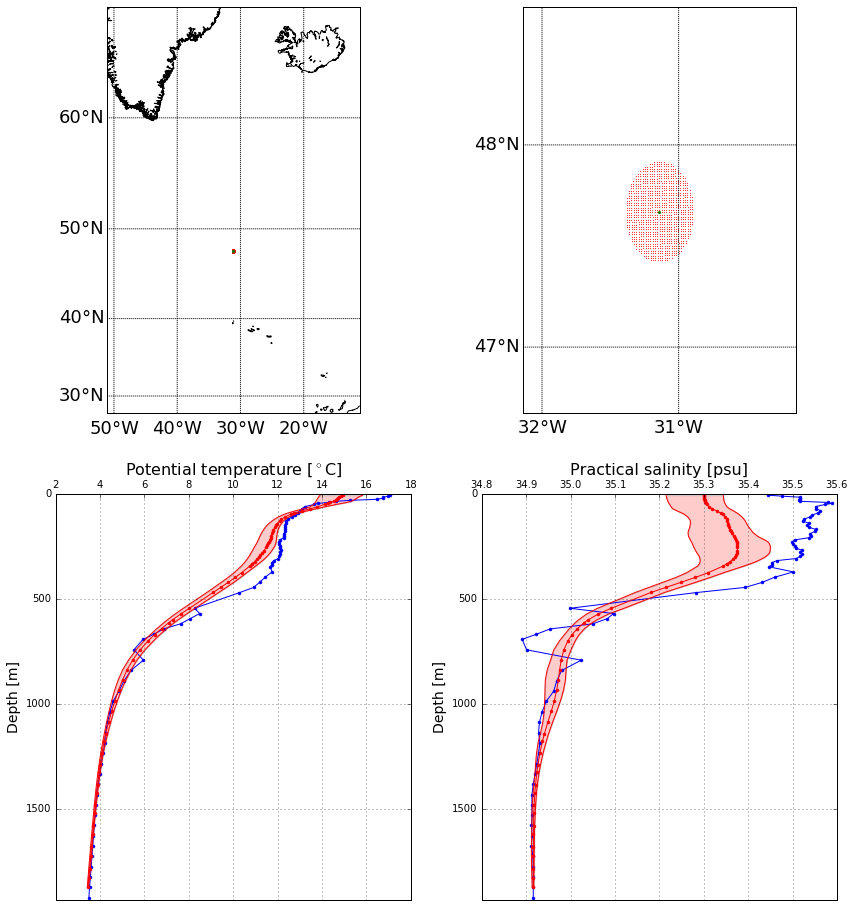

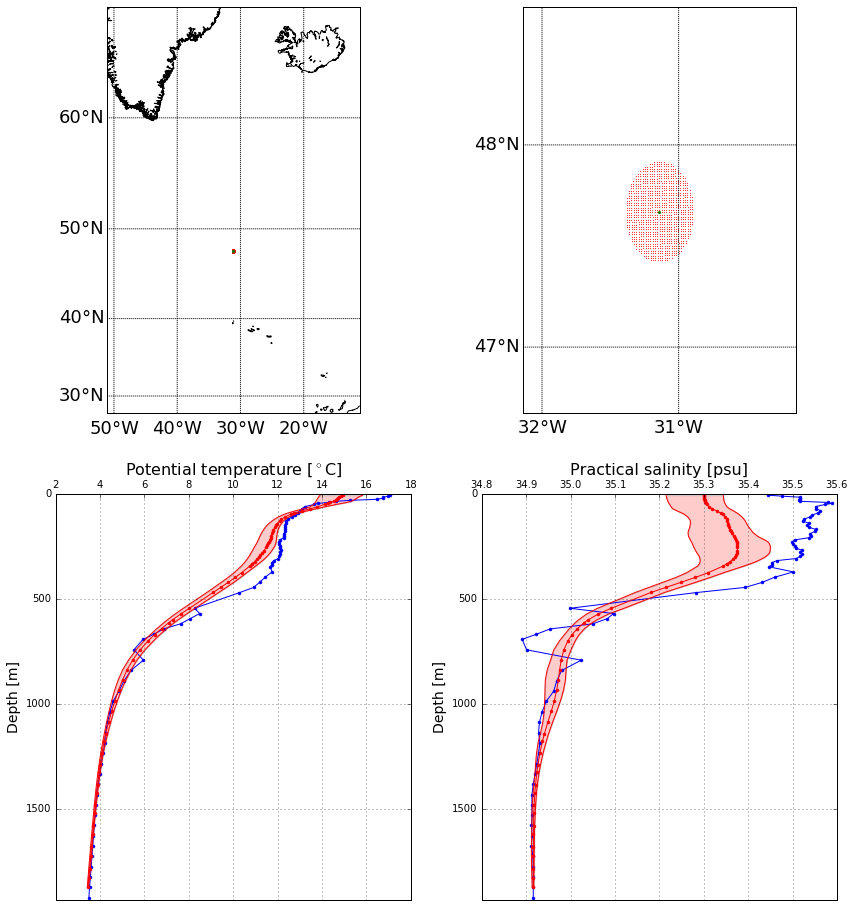

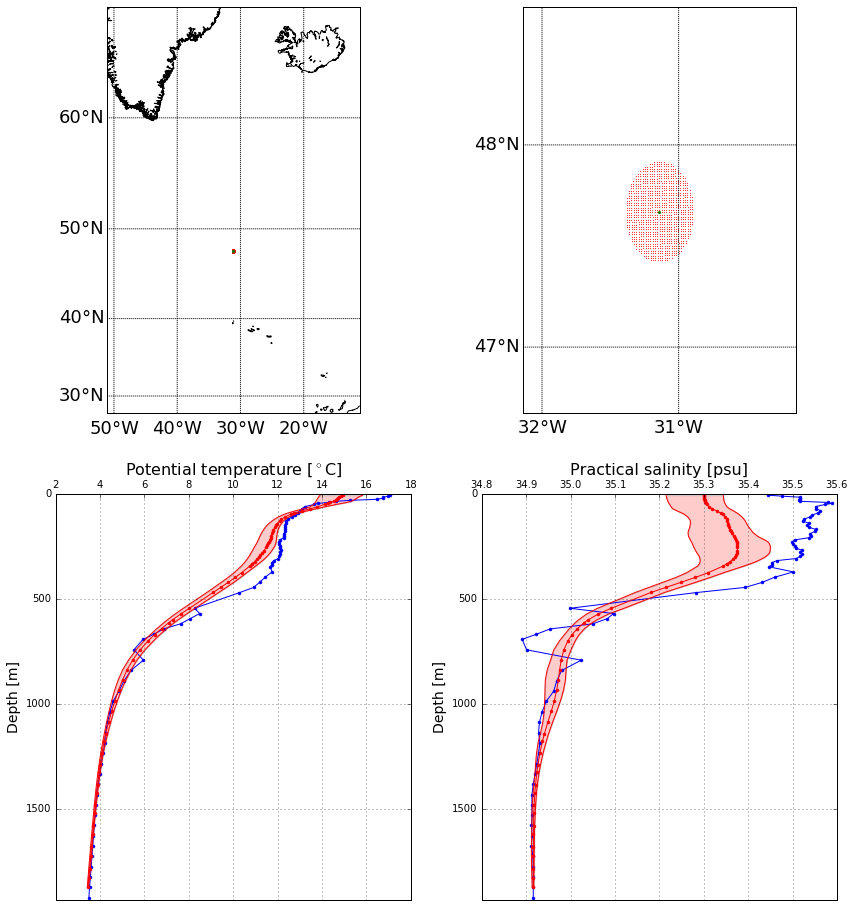

In [45]:
%timeit model_profile_temp_salt_mean_percent10_90(0)